<center>
<img src="logo.png" height="900"> 
</center>


#  Регрессия - моя профессия

В этой тетрадке мы попробуем найте BLUE-оценки и проверить пару гипотез. 

In [1]:
import numpy as np
import pandas as pd

from scipy import stats 

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Данные

In [2]:
df = pd.read_csv('Advertising.csv', index_col=0)
print(df.shape)
df.head()

(200, 4)


,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


__Описание колонок:__ 

- `Sales` - продажи продукта на данном рынке (в тысячах штук) 
- `TV` -  доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
- `Radio` - доллары, потраченные на радио рекламу
- `Newspaper` - доллары, потраченные на рекламу в газетах

В нашей выборке мы имеем 200 **наблюдений** (200 разных рынков с разным объёмом рекламы)

## Вопросы

Давайте представим, что мы работаем на компанию, которая производит и продает этот товар. Компания может задать нам вопрос: как мы должны тратить наши рекламные деньги в будущем?

Этот общий вопрос может привести вас к более конкретным вопросам:

1. Существует ли связь между рекламой и продажами?
2. Насколько сильны эти отношения?
3. Какие типы рекламы способствуют росту продаж?
4. Зная расходы на рекламу на конкретном рынке, можем ли мы предсказать продажи?

# 1. Парная регрессия в уровнях

Взглянем как продажи зависят от типов рекламы.

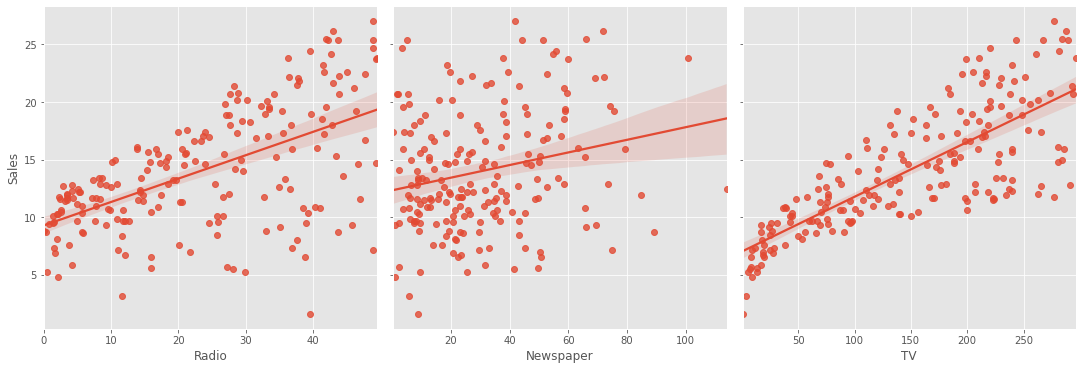

In [3]:
sns.pairplot(
    df, 
    y_vars='Sales', 
    x_vars=['Radio', 'Newspaper', 'TV'], 
    size=5,
    kind='reg',
    diag_kind=None
);

Для начала давайте поговорим только про рекламу на TV. Оценим параметры модели 

$$
Sales_i = \beta_0 + \beta_1 \cdot TV_i + \varepsilon_i
$$

In [6]:
import statsmodels.formula.api as smf

model = smf.ols('Sales ~ TV', data=df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Thu, 15 Jul 2021   Prob (F-statistic):           1.47e-42
Time:                        07:10:54   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
def my_ols(data, cols):
    summary = pd.DataFrame({})
    
    x = data[cols].values.reshape(-1, len(cols))
    y = data['Sales'].values.reshape(-1, 1)

    x = np.hstack((np.ones((len(x), 1)), x))
    w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)

    RSS = np.sum((y - x.dot(w))**2) # Residual sum of squares
    
    se_coef = np.sqrt((RSS / (len(x) - len(cols) + 1 - 1)) * np.linalg.inv(x.T.dot(x)).diagonal())
    cdf_t = stats.t(df=len(x) - len(cols) + 1 - 1).cdf(w.ravel() / se_coef)
    
    pvals = []
    for cdf in cdf_t:
        if cdf >= 0.5:
            pval = 2 * (1 - cdf)
        else:
            pval = 2 * cdf
        pvals.append(pval)
    
    summary['names'] = ['Intercept'] + cols
    summary['w'] = w
    summary['se_coef'] = se_coef
    summary['pvals'] = pvals
    summary['left'] = w.ravel() - se_coef*stats.t(df=len(x) - len(cols) + 1 - 1).ppf(1-0.05/2)
    summary['right'] = w.ravel() + se_coef*stats.t(df=len(x) - len(cols) + 1 - 1).ppf(1-0.05/2)
    return summary

In [4]:
my_ols(df, ['TV', 'Radio', 'Newspaper'])

,names,w,se_coef,pvals,left,right
0,Intercept,2.938889,0.311116,0.000000,2.325345,3.552434
1,TV,0.045765,0.001391,0.000000,0.043021,0.048509
2,Radio,0.188530,0.008589,0.000000,0.171591,0.205469
3,Newspaper,-0.001037,0.005856,0.859561,-0.012586,0.010511


In [7]:
model = smf.ols('Sales ~ TV + Radio + Newspaper', data=df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 15 Jul 2021   Prob (F-statistic):           1.58e-96
Time:                        07:10:56   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
res.params

Intercept    7.032594
TV           0.047537
dtype: float64

- Переменная $TV$ значима, так как $p$-значение для проверки гипотезы о том, что она равна нулю оказалось очень маленьким, наблюдаемое значение статистики $17.668$. Оно лежит глубоко в хвосте нашего распределения. 
- Получившееся уравнение 

$$
Sales_i = 7.033 + 0.047 \cdot TV_i
$$

можно проинтерпретировать так, что каждые дополнительные $1000$ долларов, потраченные на рекламу по телевизору, увеличивают продажы на $47.537$ товаров.

> Мы можем так интерпретировать значение коэффициента, если выполняются предпослыки линейной регрессии. Например, первая предпослыка говорит о том, что мы должны были верно специфицировать модель. 

Если модель специфицирована неверно, у нас есть проблемы. 

> Мы получаем корректные оценки стандартных ошибок в ситуации, когда ошибки независимо одинаково распределены с одинаковой дисперсией. Если это не так, оценки ошибок искажены. 

# 2. Парная регрессия в логарифмах

У нашей модели явно есть проблемы со спецификацией. Давайте попробуем их исправить. Если взглянуть на график того, как между собой взаимосвязаны реклама по TV и продажи, можно заметить нелинейную зависимость, похожую на логарифмическую. 

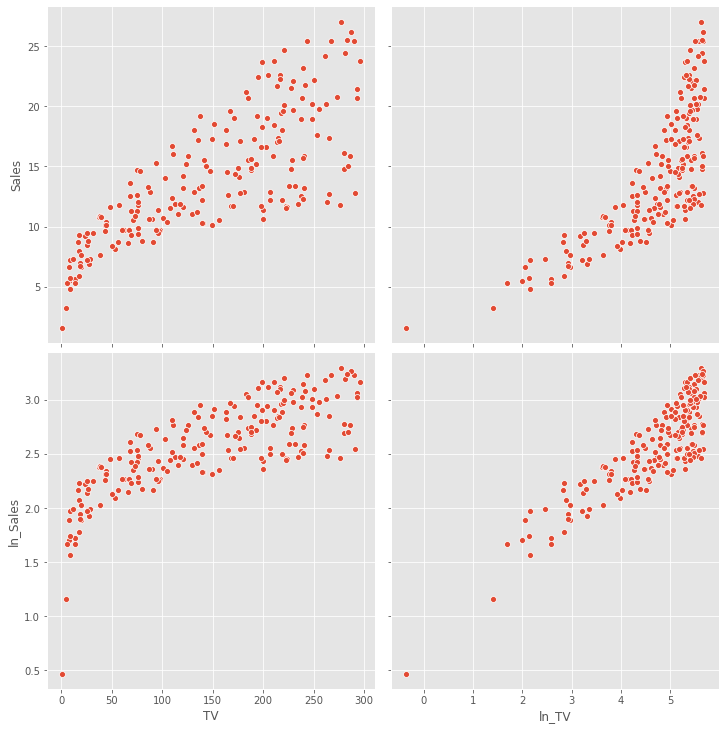

In [6]:
df['ln_TV'] = df['TV'].apply(np.log)
df['ln_Sales'] = df['Sales'].apply(np.log)

sns.pairplot(
    df, 
    y_vars=['Sales', 'ln_Sales'], 
    x_vars=['TV', 'ln_TV'], 
    size=5,
    diag_kind=None
);


Очистим данные от выбросов. 

In [7]:
df = df[df.Sales > df.Sales.quantile(0.01)]

Оценим параметры модели 

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \varepsilon_i
$$

In [8]:
import statsmodels.formula.api as smf

model = smf.ols('ln_Sales ~ ln_TV', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     435.1
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           1.16e-51
Time:                        21:38:53   Log-Likelihood:                 29.332
No. Observations:                 198   AIC:                            -54.66
Df Residuals:                     196   BIC:                            -48.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9757      0.078     12.443      0.0

Переменная снова значима. $R^2$ подрос. Все коэффициенты в моделях, где целевые и объясняющие переменные взяты в логарифмах, интерпретируются в процентных изменениях. Например, коэффициент $0.3550$ можно проинтерпретировать как то, на сколько процентов увеличутся продажи, при изменении трат на рекламу по телевизору на $1\%$. 

# 3. Множественная регрессия

Оценим уравнение 

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \beta_2 \cdot Radio_i + \beta_3 \cdot Newspaper_i + \varepsilon_i
$$

In [9]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2959.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          1.17e-161
Time:                        21:38:53   Log-Likelihood:                 294.22
No. Observations:                 198   AIC:                            -580.4
Df Residuals:                     194   BIC:                            -567.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.022     30.446      0.0

- Уравнение значимо в целом, значение F-статистики попадает глубоко в хвост 
- Коэффициент перед `Newspaper` отрицательный и незначимый

> Если модель специфицирована верно и выполнены все предпосылки, мы можем сделать вывод, что траты на рекламу в газетах никак не повышают продажи и от них можно отказаться 

# 4. Проверка предпосылок модели

- Есть ли мультиколинеарность? 

In [10]:
df[['ln_TV', 'Radio', 'Newspaper']].corr()

,ln_TV,Radio,Newspaper
ln_TV,1.000000,0.004521,-0.004387
Radio,0.004521,1.000000,0.358916
Newspaper,-0.004387,0.358916,1.000000


Между переменными нет высокой корреляции. Значит у нас получится корректно оценить нашу модель. Есть другие, более формальне критерии для поиска проблем, связанных с мультиколинеарностью, но мы про них говорить не будем. 

- Корректны ли данные, с которыми мы работаем, для решения поставленной задачи? 
- Корректна ли спецификация модели? 
- Есть ли выборосы? 

Про всё это мы поговорили выше. Судя по всему, оценки коэффициентов, которые мы получили - несмещённые и состоятельные. 

- Есть ли в остатках __автокоррелированность__?

Для проверки этой предпосылки нам достаточно посмотреть в протокол оценивания и найти там строчку `Durbin-Watson`. Это статистика Дарбина-Уотсона. Если она оказывается в районе двух, то автокоррелированности в остатках нет. На самом деле это тоже статистика и для неё есть формальные критические значения, но мы в это углубляться не будем. Есть и другие критерии для проверки этой предпосылки. 

- Есть ли в остатках __гетероскедастичность__?

Для гетероскедастичности построим картинку и воспользуемся каким-нибудь критерием. 

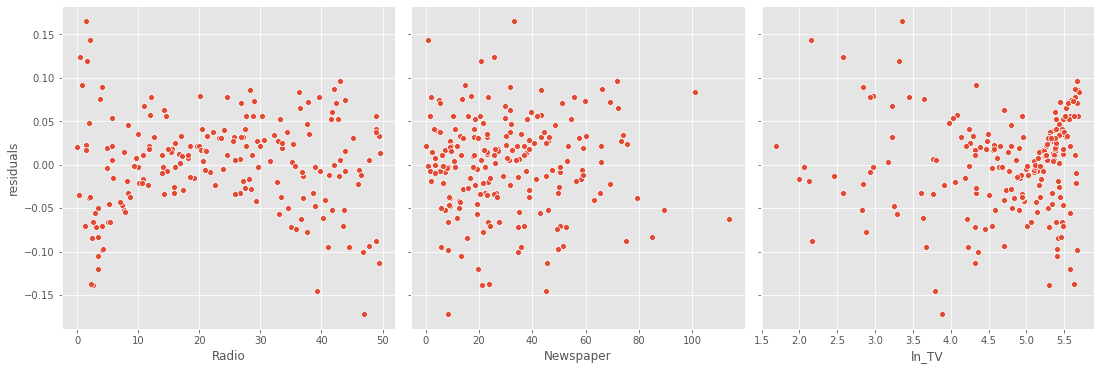

In [11]:
df['residuals'] = res.resid

sns.pairplot(
    df, 
    y_vars='residuals', 
    x_vars=['Radio', 'Newspaper', 'ln_TV'], 
    size=5,
    diag_kind=None
);

Судя по графику, дисперсия ошибок зависит от объёма рекламы по радио. Причём квадратично. Выходит, что оценки дисперсий коэффициентов искажены и доверительные интервалы оказываются смещёнными. Можно провести формальный тест на гомоскедастичность. Таких тестов есть довольно много. 

In [12]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(res.resid, df[['ln_TV', 'Radio', 'Newspaper']].values)

(51.358418350912785,
 7.0414346890960835e-12,
 22.765010819358622,
 1.1142274879397325e-12)

Видим, что `pvalue` (последнее значение) сильно ниже уровня значимости. Гипотеза о гомоскедастичности отвергается. Можно ввести корректировку и исправить значения ошибок прямо при оценивании модели. 

In [13]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1807.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          1.85e-141
Time:                        21:38:55   Log-Likelihood:                 294.22
No. Observations:                 198   AIC:                            -580.4
Df Residuals:                     194   BIC:                            -567.3
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.029     23.108      0.0

Значения стандартных ошибок довольно сильно изменились. Теперь мы можем использовать их для проверки гипотез. 

> Нормальность остатков нам не нужна. Из-за корректировки ошибок мы можем пользоваться только асимптотическими результатами. В данных нет выбросов, поэтому предельные теоремы тут работают. 

# 4. Выводы: 

1. Тратить деньги на рекламу в газетах неэффективно. Гипотеза о том, что коэффициент перед этой переменной равен нулю, не отвергается. 
2. Реклама по телевидению обладает убывающей отдачей от масштаба. Коэффициент перед логарифмом получился меньше единицы. Этот канал оказывается в плане рекламы самым эффективным. 
3. Канал, связанный с радио, судя по всему, недоиспользуется. Здравый смысл и микроэкономика подсказывают, что от него тоже логично ожидать убывающую от масштаба отдачу. Однако в данных мы видим, что она линейная. 